Import the libraries necessary to analize data

In [1]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import datetime
import random
import seaborn as sns
import plotly.express as px

In [2]:
df = pd.read_csv('df_scaled.csv')

Since we use distance metric working on numerical features we remove the categorical data and useless features 

In [3]:
column_to_drop = ['avg_age_participants','n_participants','n_participants_child', 'n_participants_teen', 'n_females', 'n_killed', 'n_injured',
       'n_arrested', 'n_unharmed','date', 'latitude', 'longitude','congressional_district', 'candidatevotes', 'totalvotes', 'involve_killing', 'involve_injury', 'involve_arrest','is_survived','pc1', 'pc2']

       
for col in df.columns:
    if df[col].dtype == 'object':
       column_to_drop.append(col)
column_to_drop

['avg_age_participants',
 'n_participants',
 'n_participants_child',
 'n_participants_teen',
 'n_females',
 'n_killed',
 'n_injured',
 'n_arrested',
 'n_unharmed',
 'date',
 'latitude',
 'longitude',
 'congressional_district',
 'candidatevotes',
 'totalvotes',
 'involve_killing',
 'involve_injury',
 'involve_arrest',
 'is_survived',
 'pc1',
 'pc2',
 'date',
 'state',
 'city_or_county',
 'incident_characteristics1',
 'party']

In [4]:
df_categorical = df[column_to_drop]
df_numeric = df.drop(columns=column_to_drop)

In [5]:
df_categorical.info()
df_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166664 entries, 0 to 166663
Data columns (total 26 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   avg_age_participants       166664 non-null  float64
 1   n_participants             166664 non-null  float64
 2   n_participants_child       166664 non-null  int64  
 3   n_participants_teen        166664 non-null  int64  
 4   n_females                  166664 non-null  float64
 5   n_killed                   166664 non-null  float64
 6   n_injured                  166664 non-null  float64
 7   n_arrested                 166664 non-null  float64
 8   n_unharmed                 166664 non-null  float64
 9   date                       166664 non-null  object 
 10  latitude                   166664 non-null  float64
 11  longitude                  166664 non-null  float64
 12  congressional_district     166664 non-null  int64  
 13  candidatevotes             16

# K-means

In [6]:
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_score

Knee Method to estimate the best K. 

We performed a nested grid search on k.

In [7]:
k_grid = [2, 3, 4, 10, 100, 1000]

sse_list = list()

label_list = []
dict_kmeans = {}
#search for the best k
for k in k_grid:

    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(df_numeric)
    
    sse = kmeans.inertia_
    labels = kmeans.labels_
    #we save a list of see and labels for each k-means tried
    dict_kmeans[f'{k}_sse'] = sse
    dict_kmeans[f'{k}_labels'] = labels

    print(f'k: {k}, SSE: {sse}')


k: 2, SSE: 1646704.8754374427
k: 3, SSE: 1366709.6017058613
k: 4, SSE: 1208515.7883790787
k: 10, SSE: 832907.1415505831
k: 100, SSE: 289536.71444840444
k: 1000, SSE: 87610.99285315689


In [8]:
for k in k_grid:
    print(f'for k = {k}')
    
    print('SSE %s' % dict_kmeans[f'{k}_sse'])
    current_bouldin = metrics.davies_bouldin_score(df_numeric, dict_kmeans[f'{k}_labels'])
    dict_kmeans[f'{k}_bouldin_score'] = current_bouldin
    print('Separation %s' % current_bouldin)
    
    current_silhouette = silhouette_score(df_numeric, dict_kmeans[f'{k}_labels'])
    dict_kmeans[f'{k}_silhouette_score'] = current_silhouette
    print('Silhouette %s' % current_silhouette)

for k = 2
SSE 1646704.8754374427
Separation 1.9813490226692585
Silhouette 0.19903279722963033
for k = 3
SSE 1366709.6017058613
Separation 1.5838557493554448
Silhouette 0.254300837664049
for k = 4
SSE 1208515.7883790787
Separation 1.3733950307938205
Silhouette 0.264042964398973
for k = 10
SSE 832907.1415505831
Separation 1.489964560817611
Silhouette 0.262920957845508
for k = 100
SSE 289536.71444840444
Separation 1.3529026742512231
Silhouette 0.24274599182465187
for k = 1000
SSE 87610.99285315689
Separation 1.243425788246572
Silhouette 0.2844280091959797


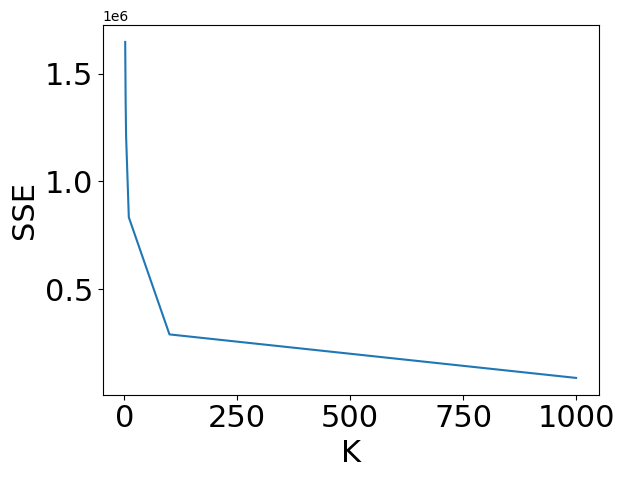

In [9]:
sse_list = [dict_kmeans[f'{k}_sse'] for k in k_grid]
plt.plot(k_grid,sse_list)
plt.ylabel('SSE', fontsize=22)
plt.xlabel('K', fontsize=22)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.show()

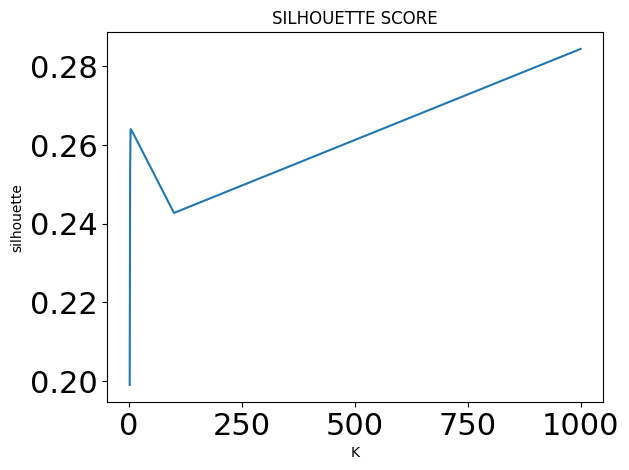

In [10]:
silhouette_list = [dict_kmeans[f'{k}_silhouette_score'] for k in k_grid]
plt.plot(k_grid, silhouette_list)
plt.ylabel('silhouette')
plt.xlabel('K')
plt.tick_params(axis='both', which='major', labelsize=22)
plt.title('SILHOUETTE SCORE')
#plt.axvline(6)
plt.show()

From both elbow method and silhouette score, best K is around 4.

In [11]:
#RETRAIN BEST K-MEANS
best_k = 3
best_kmeans = KMeans(n_clusters=best_k, n_init=10, max_iter=100)
best_kmeans.fit(df_numeric)

KMeans(max_iter=100, n_clusters=3, n_init=10)

In [12]:
# Calculate number of clusters for final kmeans
n_clusters = len(np.unique(best_kmeans.labels_))

# Calculate list of label occurrencies for each cluster
occ_list = []
for k in range(n_clusters):
    occ_list.append(np.count_nonzero(best_kmeans.labels_ == k))

print('cluster sizes:', occ_list)

cluster sizes: [71053, 40719, 54892]


Plotting the result of the clustering on the pca dimensions (pc1 and pc2), labelling each point by the cluster label

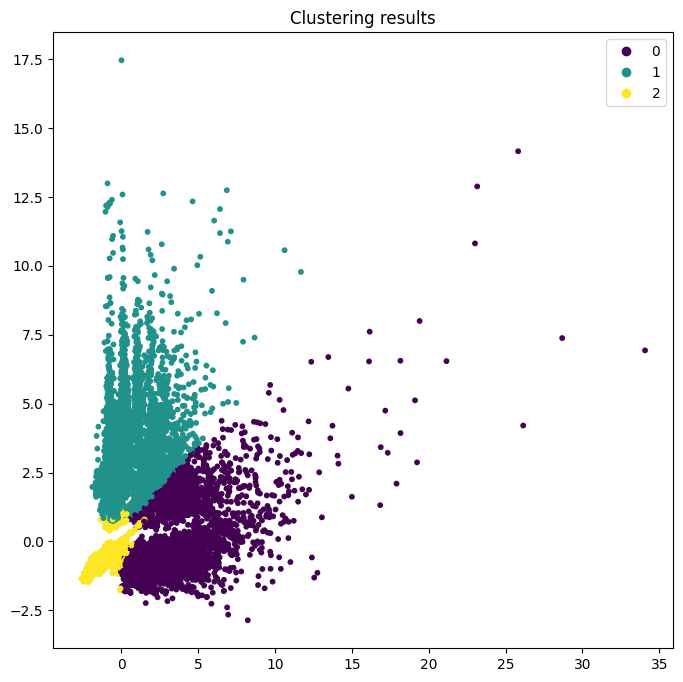

In [13]:
plt.figure(figsize=(8,8))
scatter = plt.scatter(df['pc1'], df['pc2'], c=best_kmeans.labels_, s=10)

plt.tick_params(axis='both', which='major')
plt.title("Clustering results")
plt.legend(*scatter.legend_elements())

Plot of cluster labels distribution

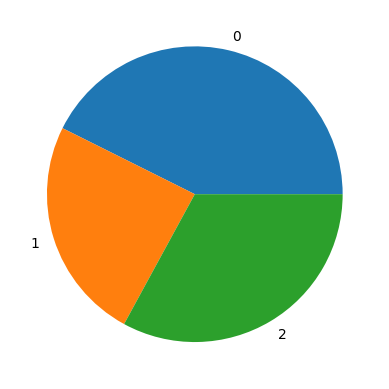

In [14]:
label= range(n_clusters)
plt.pie(occ_list, labels=label, colors=sns.color_palette(n_colors=n_clusters))
plt.show()

Involve_killing or not distribution

As we can see the number of killed persons in 2 out of 3 clusters is 0.

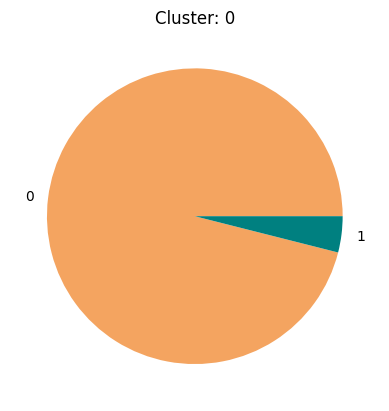

involve_killing
0    68249
1     2804
Name: count, dtype: int64


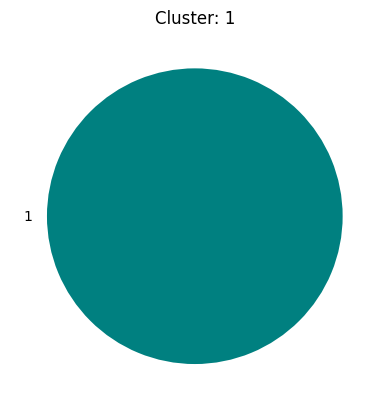

involve_killing
1    40719
Name: count, dtype: int64


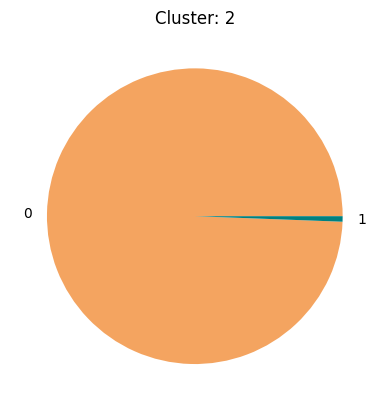

involve_killing
0    54565
1      327
Name: count, dtype: int64


In [15]:
# Calculate number of clusters for final kmeans
n_clusters = len(np.unique(best_kmeans.labels_))
dict_colors_involve_killing = { 1: 'teal', 0: 'sandybrown'}


for k in range(n_clusters):
    # Get 'bot' values for elems in cluster k
    killing_for_clust = df_categorical['involve_killing'].loc[best_kmeans.labels_ == k].value_counts()
    # Show pie plot
    labels = ['not-killed', 'killed']
    plt.title('Cluster: ' + str(k))
    plt.pie(killing_for_clust, labels= killing_for_clust.index, colors=[dict_colors_involve_killing[v] for v in killing_for_clust.keys()])
    plt.show()
    print(killing_for_clust)

# X Means 
#### from: https://github.com/annoviko/pyclustering/

In [16]:
from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer

In [17]:
start_centroids = 7
start_clusters = kmeans_plusplus_initializer(df_numeric, start_centroids, random_state=42).initialize()
 
x_means = xmeans(df_numeric, start_clusters, tolerance=1e-6, kmax=10, repeat=10, random_state=42)
x_means.process()
 
# Clustering results:
print(f'Number of clusters found:', np.shape(x_means.get_centers())[0])
print("SSE:", x_means.get_total_wce())

OSError: dlopen(/Users/lau/Library/Python/3.11/lib/python/site-packages/pyclustering/core/64-bit/macos/libpyclustering.so, 0x0006): tried: '/Users/lau/Library/Python/3.11/lib/python/site-packages/pyclustering/core/64-bit/macos/libpyclustering.so' (mach-o file, but is an incompatible architecture (have 'x86_64', need 'arm64')), '/System/Volumes/Preboot/Cryptexes/OS/Users/lau/Library/Python/3.11/lib/python/site-packages/pyclustering/core/64-bit/macos/libpyclustering.so' (no such file), '/Users/lau/Library/Python/3.11/lib/python/site-packages/pyclustering/core/64-bit/macos/libpyclustering.so' (mach-o file, but is an incompatible architecture (have 'x86_64', need 'arm64'))

In [ ]:
labels = {}
clusters = x_means.get_clusters()
n_clusters = np.shape(clusters)[0]
#transforming each cluster list from [[cluster1 m points], ...., [clustern p points]] to [[1,1,,....,1 m times], [n,....,n p times]] 
#to {point1:labelcluster1,...., pointm:labelcluster1, ....., point1:labelclustern, ...., pointp:labelclustern} sorted by number of example.
for cluster_label in range(0, n_clusters):
  for i in range(0, len(clusters[cluster_label])):
      labels[clusters[cluster_label][i]] = cluster_label

labels = dict(sorted(labels.items()))
xmeans_labels = list(labels.values())

NameError: name 'x_means' is not defined

In [ ]:
print('Separation %s' % metrics.davies_bouldin_score(df_numeric, xmeans_labels)) # lower value, better clustering (minimum zero)
print('Silhouette %s' % silhouette_score(df_numeric, xmeans_labels))

Separation 1.4333188536330668
Silhouette 0.2239619283502909


In [ ]:
# Calculate list of label occurrencies for each cluster
occ_list = []
for k in range(n_clusters):
    occ_list.append(np.count_nonzero(np.array(xmeans_labels) == k))

print('cluster occurrencies:', occ_list)

cluster occurrencies: [29411, 12321, 25239, 6351, 17349, 16434, 23126, 35612, 14019, 18052]


Plot of cluster labels distribution

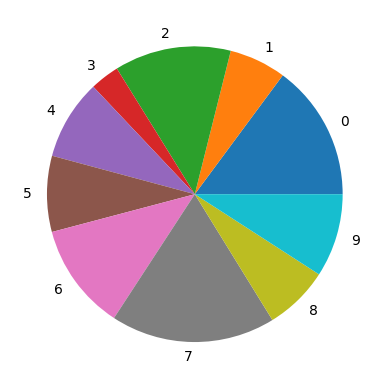

In [ ]:
label= range(n_clusters)
plt.pie(occ_list, labels=label, colors=sns.color_palette(n_colors=n_clusters))
plt.show() 

We can see from distribution that the number of records are not really well distributed, we will probably test more and see what happens later.

Involve_killing or not distribution

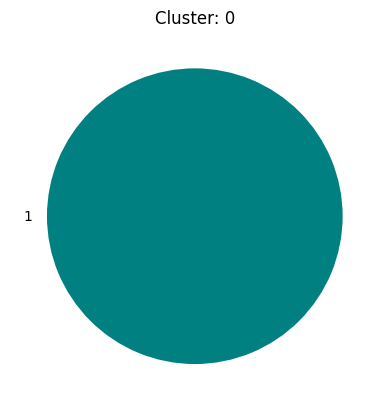

involve_killing
1    29411
Name: count, dtype: int64


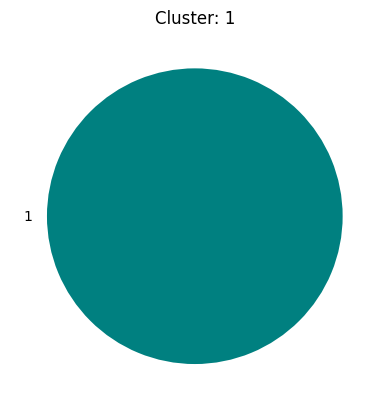

involve_killing
1    12321
Name: count, dtype: int64


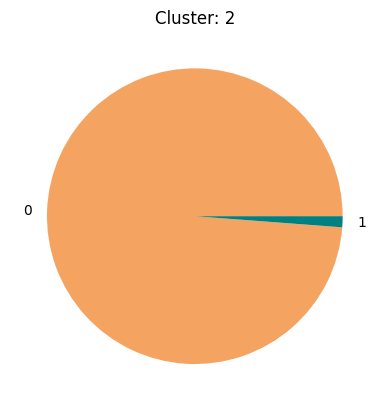

involve_killing
0    24936
1      303
Name: count, dtype: int64


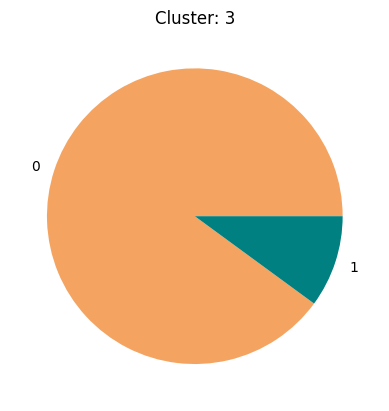

involve_killing
0    5712
1     639
Name: count, dtype: int64


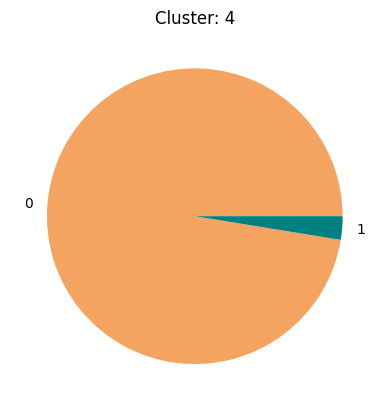

involve_killing
0    16905
1      444
Name: count, dtype: int64


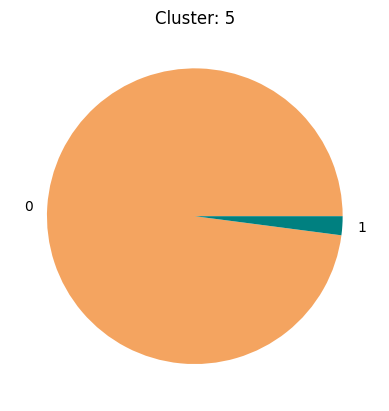

involve_killing
0    16095
1      339
Name: count, dtype: int64


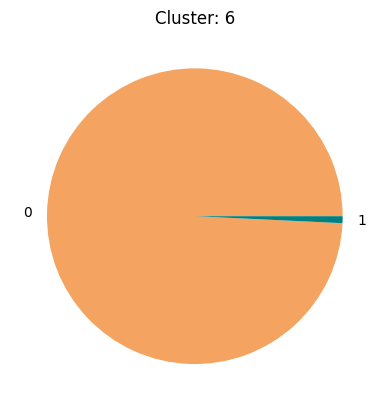

involve_killing
0    22952
1      174
Name: count, dtype: int64


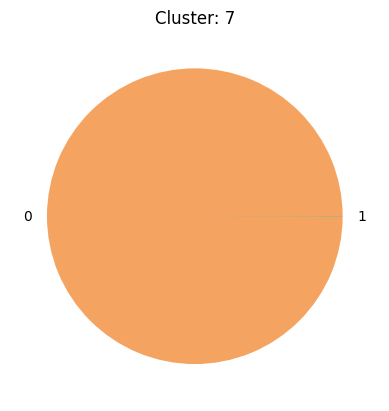

involve_killing
0    35603
1        9
Name: count, dtype: int64


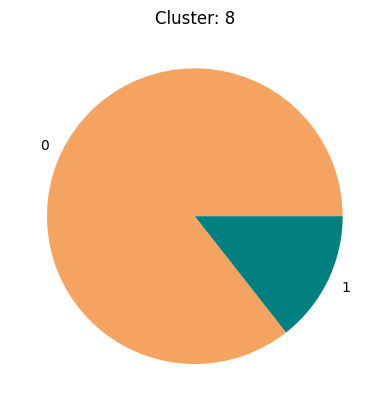

involve_killing
0    11999
1     2020
Name: count, dtype: int64


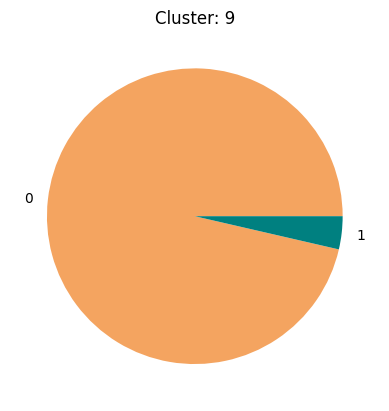

involve_killing
0    17401
1      651
Name: count, dtype: int64


In [ ]:
dict_colors_involve_killing = { 1: 'teal', 0: 'sandybrown'}

for k in range(n_clusters):
    # Get 'bot' values for elems in cluster k
    killing_for_clust = df_categorical['involve_killing'].loc[np.array(xmeans_labels) == k].value_counts()
    # Show pie plot
    labels = ['not-killed', 'killed']
    plt.title('Cluster: ' + str(k))
    plt.pie(killing_for_clust, labels= killing_for_clust.index, colors=[dict_colors_involve_killing[v] for v in killing_for_clust.keys()])
    plt.show()
    print(killing_for_clust)